**Busniness Understanding**

This dataset is related to the video gaming industry and a survey was conducted to build a 
recommendation engine so that the store can improve the sales of its gaming DVDs. Build a 
Recommendation Engine and suggest top-selling DVDs to the store customers

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
upload = files.upload()

Saving Dataset_new.csv to Dataset_new (1).csv


In [ ]:
df = pd.read_csv('Dataset_new.csv')
df.head()

,userId,gameId,rating
0,3,1,4.0
1,6,2,5.0
2,8,3,4.0
3,10,4,4.0
4,11,3,4.5


In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["gameId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["game"] = df["gameId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_game = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of DVD Games: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_game, min_rating, max_rating
    )
)

Number of users: 3261, Number of DVD Games: 3434, Min rating: 0.5, Max rating: 5.0


In [ ]:
#Check for missing values
print('Number of missing values:')
pd.DataFrame(df.isnull().sum().reset_index()).rename( columns={0:"Total missing","index":"Columns"}) 

Number of missing values:


,Columns,Total missing
0,userId,0
1,gameId,0
2,rating,0
3,user,0
4,game,0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "game"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
x

array([[1501, 1062],
       [  48, 1803],
       [2602,  278],
       ...,
       [2738, 2147],
       [ 169, 2595],
       [ 860,  321]])

In [ ]:
EMBEDDING_SIZE = 40


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_game, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_game = num_game
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_game,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_game, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_game, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=60,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/15
75/75 [==============================] - 2s 9ms/step - loss: 0.6936 - val_loss: 0.6928
Epoch 2/15
75/75 [==============================] - 0s 6ms/step - loss: 0.6250 - val_loss: 0.6916
Epoch 3/15
75/75 [==============================] - 0s 6ms/step - loss: 0.6167 - val_loss: 0.6912
Epoch 4/15
75/75 [==============================] - 1s 7ms/step - loss: 0.6139 - val_loss: 0.6910
Epoch 5/15
75/75 [==============================] - 1s 8ms/step - loss: 0.6118 - val_loss: 0.6905
Epoch 6/15
75/75 [==============================] - 0s 6ms/step - loss: 0.6096 - val_loss: 0.6903
Epoch 7/15
75/75 [==============================] - 0s 7ms/step - loss: 0.6078 - val_loss: 0.6904
Epoch 8/15
75/75 [==============================] - 0s 6ms/step - loss: 0.6055 - val_loss: 0.6901
Epoch 9/15
75/75 [==============================] - 0s 5ms/step - loss: 0.6048 - val_loss: 0.6904
Epoch 10/15
75/75 [==============================] - 0s 6ms/step - loss: 0.6072 - val_loss: 0.6894
Epoch 11/15
75/75 [

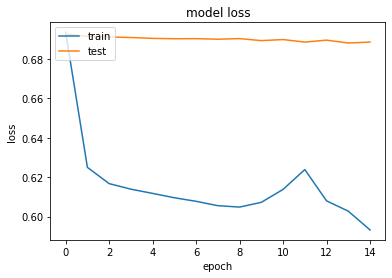

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
game_df = pd.read_csv("Game.csv")
game_df.head()

,gameid,game
0,1,The Legend of Zelda: Ocarina of Time
1,2,Tony Hawk's Pro Skater 2
2,3,Grand Theft Auto IV
3,4,SoulCalibur
4,5,Super Mario Galaxy


In [ ]:

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = game_df[
    ~game_df["gameid"].isin(movies_watched_by_user.gameId.values)
]["gameid"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("DVD Game with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .gameId.values
)
movie_df_rows = game_df[game_df["gameid"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.game)

print("----" * 8)
print("Top 10 DVD Game recommendations")
print("----" * 8)
recommended_games = game_df[game_df["gameid"].isin(recommended_movie_ids)]
for row in recommended_games.itertuples():
    print(row.game)

Showing recommendations for user: 721
DVD Game with high ratings from user
--------------------------------
V-Rally 3
--------------------------------
Top 10 DVD Game recommendations
--------------------------------
NHL 2002
Rock Band 2
NBA 2K13
The Banner Saga 3
OlliOlli2: Welcome to Olliwood
Tom Clancy's Splinter Cell: Conviction
Indigo Prophecy
NASCAR Thunder 2003
NBA 2K10
LEGO Marvel Super Heroes
